**TRAINING BEGINS**

In [3]:
from monai.utils import first
import matplotlib.pyplot as plt
import torch
import os
import numpy as np
from monai.losses import DiceLoss
from tqdm import tqdm
import os
from glob import glob
import shutil
from tqdm import tqdm
#import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss

import torch


In [2]:
def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it 
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights` 
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)
#epoch 1 -- loss = 0.9 /dice
#epoch 2 --> loss = 0.8 /
#save model in epoch 2 example
#epoch 3 -- > loss= 0.85 no need to save the weights
#dont save in epoch 3

#val data 
#dice = 0.1 -- > epoch1
#dice -0.2 --> epoch 2
def train(model, data_in, loss, optim, max_epochs, model_dir, val_interval=1 , device=torch.device("cpu")): #val interval -validation
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_val = []
    save_metric_train = []
    save_metric_val = []
    train_loader, val_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))
            # print("oputput",volume)
            # print("length oputput",volume.size())
            # print("length label",label.size())
            # print("both",(volume.to(device).size(), label.to(device).size()))
            print("Size of inputs :", volume.shape)
            print("Size of inputs[0] :", label[0].shape)
            optim.zero_grad()
            
            outputs = model(volume)
            
            # print("helo")
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(train_loader) // train_loader.batch_size}, "
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % val_interval == 0:

            model.eval()
            with torch.no_grad():
                val_epoch_loss = 0
                val_metric = 0
                epoch_metric_val = 0
                val_step = 0

                for val_data in val_loader:

                    val_step += 1

                    val_volume = val_data["vol"]
                    val_label = val_data["seg"]
                    val_label = val_label != 0
                    val_volume, val_label = (val_volume.to(device), val_label.to(device),)
                    
                    val_outputs = model(val_volume)
                    
                    val_loss = loss(val_outputs, val_label)
                    val_epoch_loss += val_loss.item()
                    val_metric = dice_metric(val_outputs, val_label)
                    epoch_metric_val += val_metric
                    
                
                val_epoch_loss /= val_step
                print(f'val_loss_epoch: {val_epoch_loss:.4f}')
                save_loss_val.append(val_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_val.npy'), save_loss_val)

                epoch_metric_val /= val_step
                print(f'val_dice_epoch: {epoch_metric_val:.4f}')
                save_metric_val.append(epoch_metric_val)
                np.save(os.path.join(model_dir, 'metric_val.npy'), save_metric_val)

                if epoch_metric_val > best_metric:
                    best_metric = epoch_metric_val
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {val_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

def show_patient(data, SLICE_NUMBER=1, train=True, test=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need 
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize 
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `test`: this parameter is to say that you want to display a patient from the testing patients.
    """

    check_patient_train, check_patient_test = data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)

    
    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val


import nibabel as nib
from glob import glob

def get_pixdim(image_path):
    img = nib.load(image_path)
    pixdim = img.header.get_zooms()
    return pixdim

def get_pixdims_in_folder(folder_path):
    image_paths = glob(os.path.join(folder_path, '*.nii.gz'))
    
    pixdims = []
    for image_path in image_paths:
        pixdim = get_pixdim(image_path)
        pixdims.append(pixdim)
    
    return pixdims

# Example usage
folder_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/BrainNCCT/data/Final_nifti_files/TrainVolumes'
all_pixdims = get_pixdims_in_folder(folder_path)
print("Pixel Dimensions for all images:")
for i, pixdim in enumerate(all_pixdims, start=1):
    print(f"Image {i}: {pixdim}")


In [3]:
def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=-26, a_max=226, spatial_size=[128,128,28], cache=True):
#def prepare(in_dir, pixdim=[(1.0, 1.0, 1.0),(1.0, 1.0, 1.0),(0.468, 0.468, 3.0),(0.4453125, 0.4453125, 5.0)], a_min=-26, a_max=226, spatial_size=[512,512,40], cache=False):

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    path_val_volumes = sorted(glob(os.path.join(in_dir, "ValVolumes", "*.nii.gz")))
    path_val_segmentation = sorted(glob(os.path.join(in_dir, "ValSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)]

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

        ]
    )
    val_transforms = Compose(
    # val_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
        val_loader = DataLoader(val_ds, batch_size=1)

        return train_loader, val_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        val_ds = Dataset(data=val_files, transform=val_transforms)
        val_loader = DataLoader(val_ds, batch_size=1)

        return train_loader, val_loader

import os
import nibabel as nib

folder_path = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/NCCT/data/Final_nifti_files/TrainSegmentation'

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.nii.gz'):
        file_path = os.path.join(folder_path, filename)

        # Load the NIfTI file
        img = nib.load(file_path)

        # Get the data array and its shape
        data = img.get_fdata()
        shape = data.shape

        # Check the number of channels
        num_channels = shape[-1] if len(shape) >= 4 else 1

        print(f"File: {filename}, Number of channels: {num_channels}")


In [4]:
data_dir = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/BrainNCCT/data/Final_nifti_files'
model_dir = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/BrainNCCT/Model30ep' 
data_in = prepare(data_dir)
print(data_in)

device = torch.device("cpu")
model = UNet(
    dimensions=3,  #for 3d seg
    in_channels=1,   #each slice has only one channel
    out_channels=2,   #one for backgrund and naother for foreground
    channels=(16, 32, 64, 128, 256), 
    #strides=(2, 2, 2, 2),
    strides=(1, 1, 1, 1),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)



#loss_function = DiceCELoss(to_onehot_y=True, sigmoid=True, squared_pred=True, ce_weight=calculate_weights(1792651250,2510860).to(device))
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer, 30, model_dir)

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]


(<monai.data.dataloader.DataLoader object at 0x7f33d2b7b940>, <monai.data.dataloader.DataLoader object at 0x7f33d2acde80>)
----------
epoch 1/30
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
1/10, Train_loss: 0.5823
Train_dice: 0.4177
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
2/10, Train_loss: 0.5404
Train_dice: 0.4596
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
3/10, Train_loss: 0.5487
Train_dice: 0.4513
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
4/10, Train_loss: 0.5325
Train_dice: 0.4675
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
5/10, Train_loss: 0.5266
Train_dice: 0.4734
Size of inputs : torch.Size([1, 1, 128, 128, 28])
Size of inputs[0] : torch.Size([1, 128, 128, 28])
6/10, Train_loss: 0.5795
Train_dice

**Analyzing Results and Testing The Model**

In [122]:
model_dir = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/BrainNCCT/Model30ep' 

In [123]:
train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
test_loss = np.load(os.path.join(model_dir, 'loss_val.npy'))
test_metric = np.load(os.path.join(model_dir, 'metric_val.npy'))

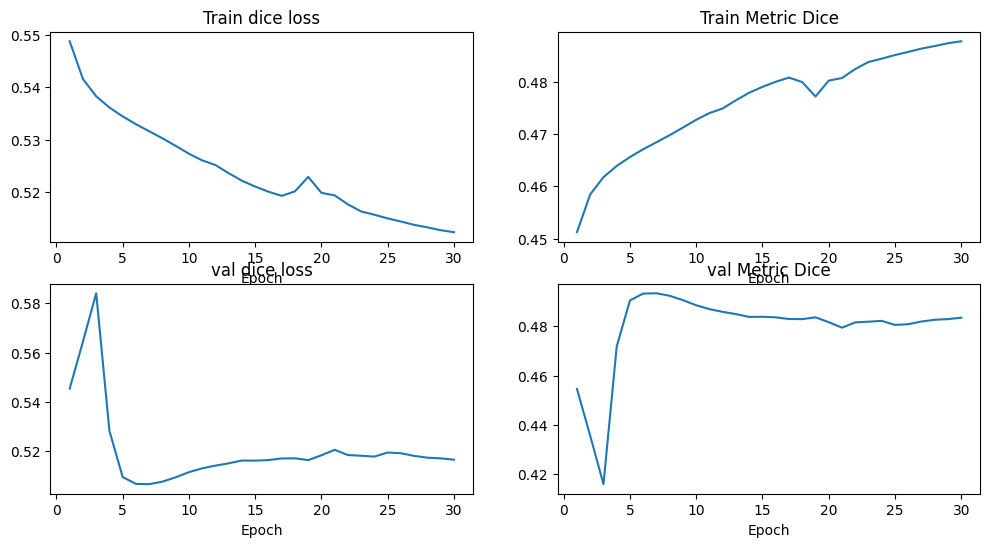

In [124]:
plt.figure("Results", (12,6))
plt.subplot(2,2,1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("Epoch")
plt.plot(x,y)

plt.subplot(2,2,2)
plt.title("Train Metric Dice")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("Epoch")
plt.plot(x,y)

plt.subplot(2,2,3)
plt.title("val dice loss")
x = [i + 1 for i in range(len(test_loss))]
y = test_loss
plt.xlabel("Epoch")
plt.plot(x,y)

plt.subplot(2,2,4)
plt.title("val Metric Dice")
x = [i + 1 for i in range(len(test_loss))]
y = test_metric
plt.xlabel("Epoch")
plt.plot(x,y)

plt.show()

**Testing Started **

In [12]:
from monai.utils import first
from monai.utils import set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import DataLoader, Dataset, CacheDataset
import torch
from glob import glob
import numpy as np
from monai.inferers import sliding_window_inference
import matplotlib.pyplot as plt

In [6]:
data_dir = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/NCCT/data/Final_nifti_files' 
model_dir = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/raunakkumar21101/code/Users/raunakkumar2110/BrainNCCT/Model30ep' 
# path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVolumes", "ProxmedImg043_0.nii.gz")))
# path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSegmentation", "ProxmedImg043_0.nii.gz")))
path_test_volumes = sorted(glob(os.path.join(data_dir, "PredVolumes", "ProxmedImg043_0.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(data_dir, "PredSegmentation", "ProxmedImg043_0.nii.gz")))

test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_files = test_files[0:41] #accordingly adjust according to the no of depths of the nifti files else it would be index out of bound error.
#applying same transformation whcih applied at the time of training
t_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=(1.0,1.0,1.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=-26, a_max=226, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=[128,128,40]),  #change according to no of slices for u  
            ToTensord(keys=["vol", "seg"]),]
    )

In [7]:
test_ds = Dataset(data = test_files,transform = t_transforms)
test_loader = DataLoader(test_ds, batch_size=1)
print(len(test_loader))

1


In [8]:
device = torch.device("cpu")
model = UNet(
    dimensions=3,  #for 3d seg
    in_channels=1,   #each slice has only one channel
    out_channels=2,   #one for backgrund and naother for foreground
    channels=(16, 32, 64, 128, 256), 
    strides=(1, 1, 1, 1),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

In [9]:
model.load_state_dict(torch.load(os.path.join(model_dir,"best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(
            (unit0)

**Saving as .nii.gz**  **NIFTI FILES**

In [10]:
import torch
import numpy as np
import nibabel as nib
from monai.transforms import Activations

# Your existing code...
sw_batch_size = 1
# roi_size = (128, 128, 28)   #adjust as per no of slices in ur data
roi_size = (128, 128, 40)

# Assuming that 'model' is an instance of your trained model
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient["vol"]

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.90

    # Convert boolean data to np.uint8
    predicted_data = test_outputs.detach().cpu()[0, 1].numpy().astype(np.uint8)

    # Create NIfTI image from the predicted output
    predicted_nii = nib.Nifti1Image(predicted_data, affine=np.eye(4))

    # Save the predicted NIfTI image
    nib.save(predicted_nii, 'predicted_output.nii.gz')


**Making gif of the output**

In [148]:
import torch
import imageio
import matplotlib.pyplot as plt

sw_batch_size = 1

# roi_size = (128, 128, 28)   #adjust as per no of slices in ur data
roi_size = (128, 128, 40)

# Assuming your 'first' and 'sliding_window_inference' functions are properly defined
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient["vol"]

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.90

    # Create a list to store frames
    frames = []

    for i in range(40):
        # Plotting the slice [:,:,80]
        plt.figure("Check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")

        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap="gray")

        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(test_outputs.detach().cpu()[0, 1, :, :, i], cmap="gray")

        # Save the current frame
        frame_path = f"frame_{i}.png"
        plt.savefig(frame_path)
        plt.close()

        # Append the frame path to the list
        frames.append(frame_path)

    # Use imageio to create a GIF from the saved frames
    output_gif_path = "output.gif"
    imageio.mimsave(output_gif_path, [imageio.imread(frame) for frame in frames])

    print(f"GIF created : {output_gif_path}")


/tmp/ipykernel_7851/835240602.py:48: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.mimsave(output_gif_path, [imageio.imread(frame) for frame in frames])


GIF created and saved at: output.gif


**Visualizing the results [Image, Mask, Predicted Mask] with individual dice scores for each image and their Mean At Last**

Dice score for slice 0: 3.333322183607379e-06


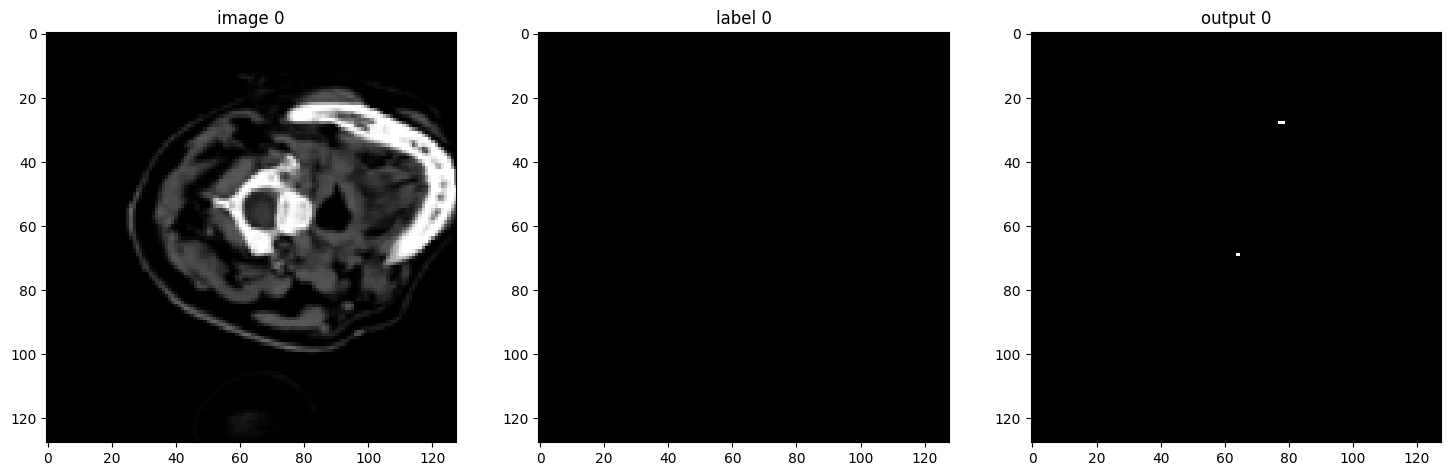

Dice score for slice 1: 1.0


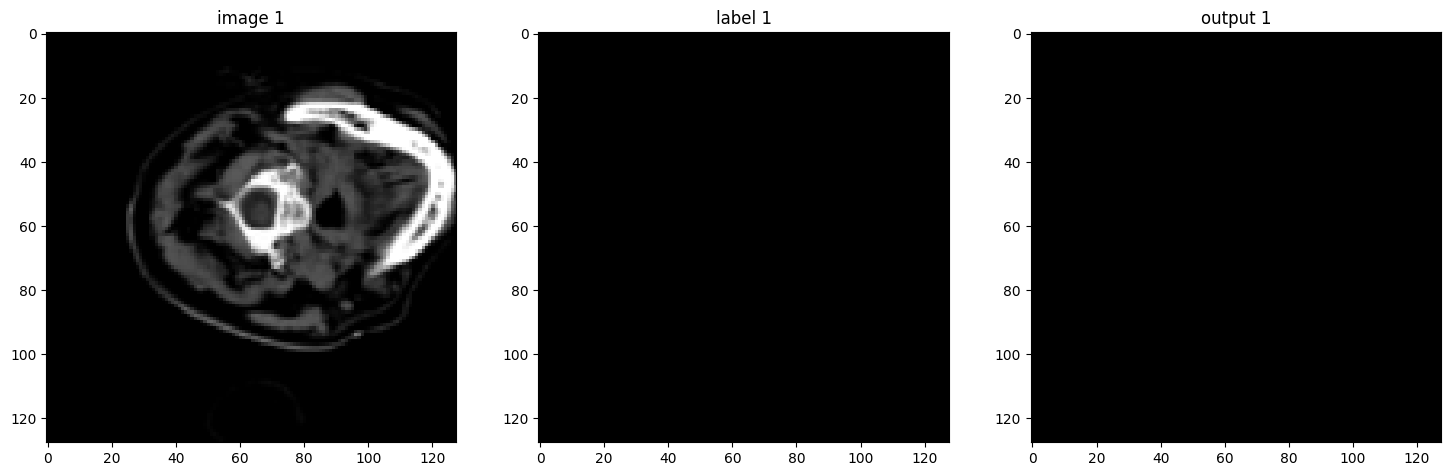

Dice score for slice 2: 1.0


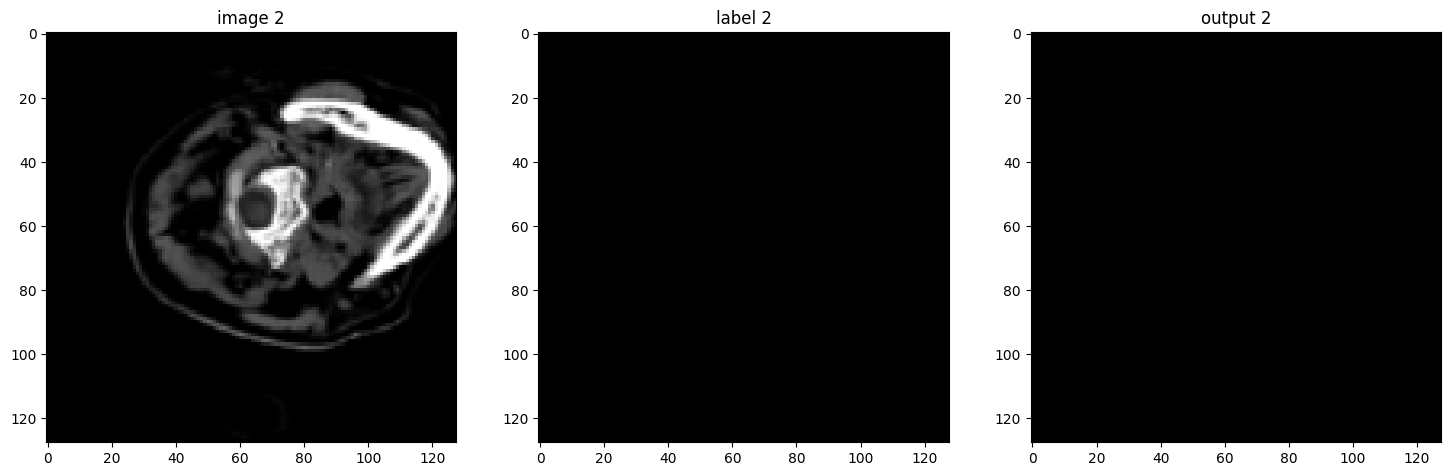

Dice score for slice 3: 1.0


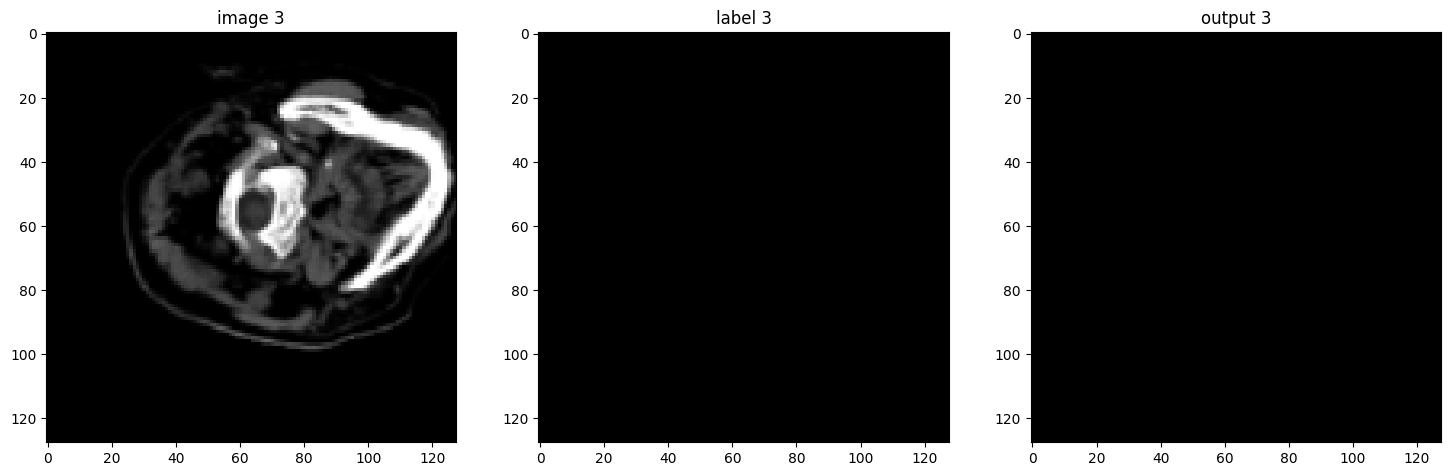

Dice score for slice 4: 1.0


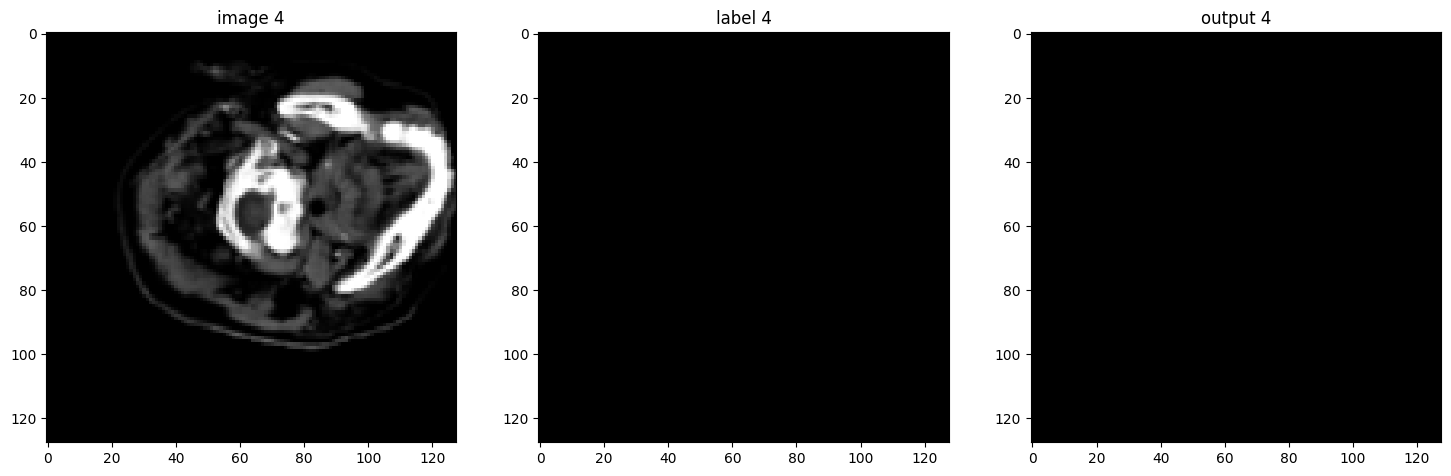

Dice score for slice 5: 1.0


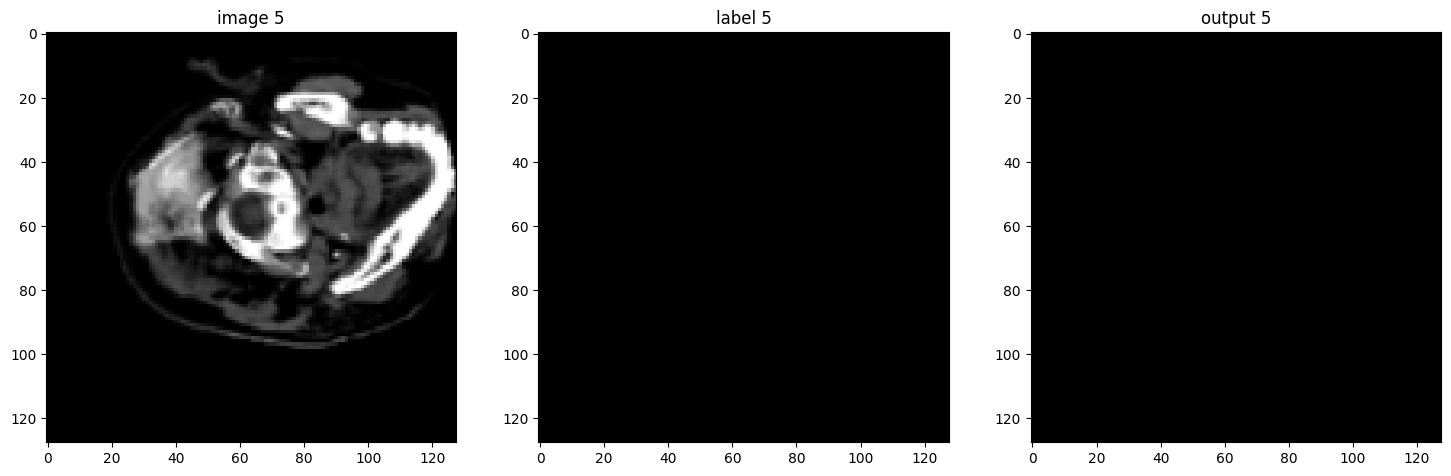

Dice score for slice 6: 1.4285693623605766e-06


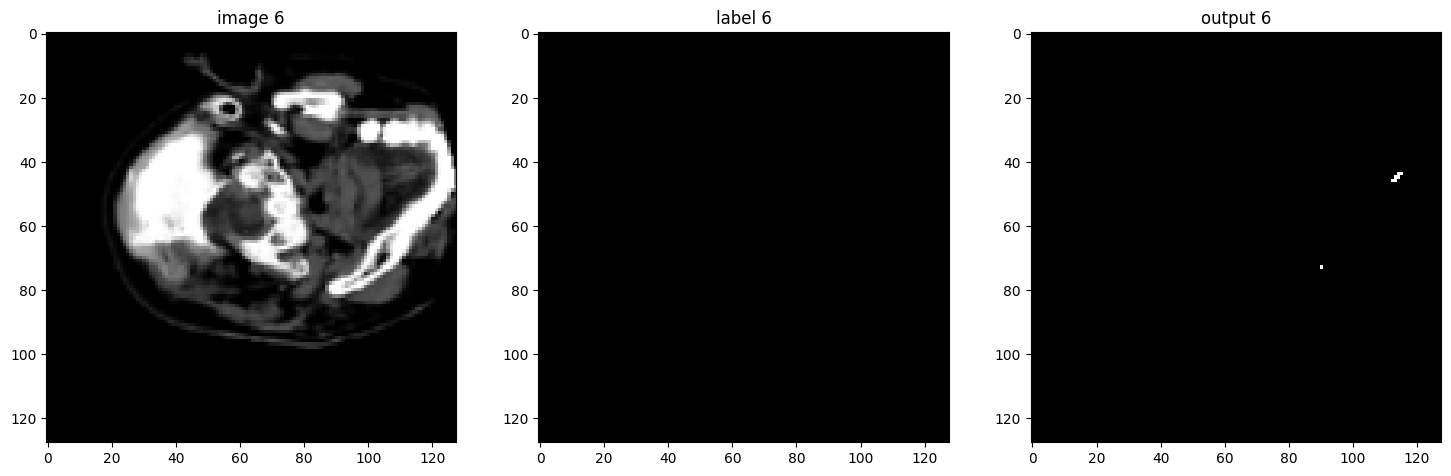

Dice score for slice 7: 7.692302119721717e-07


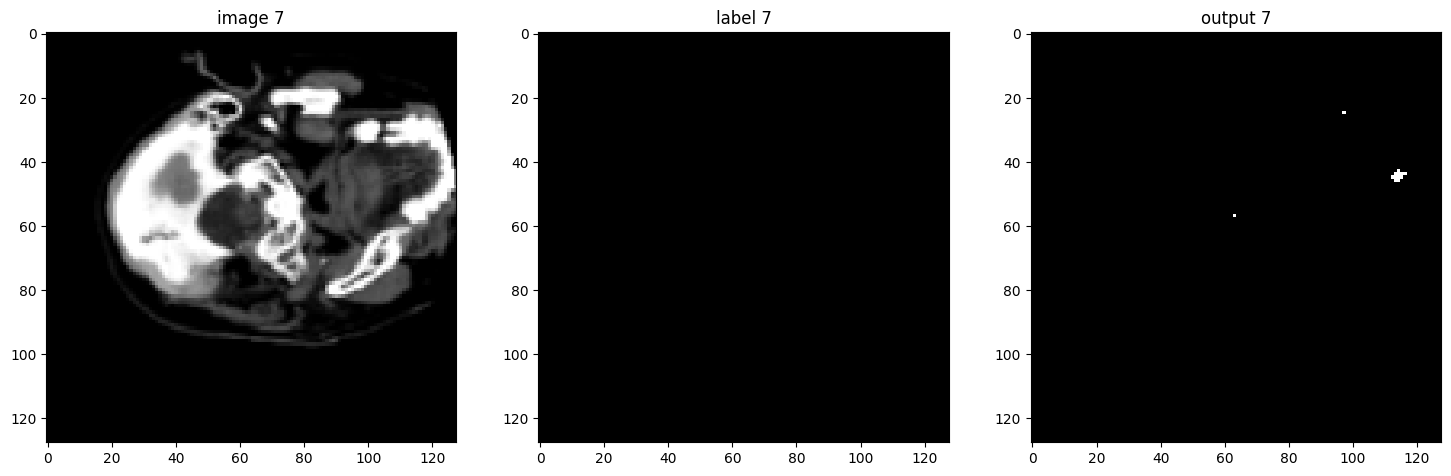

Dice score for slice 8: 7.142851927710581e-07


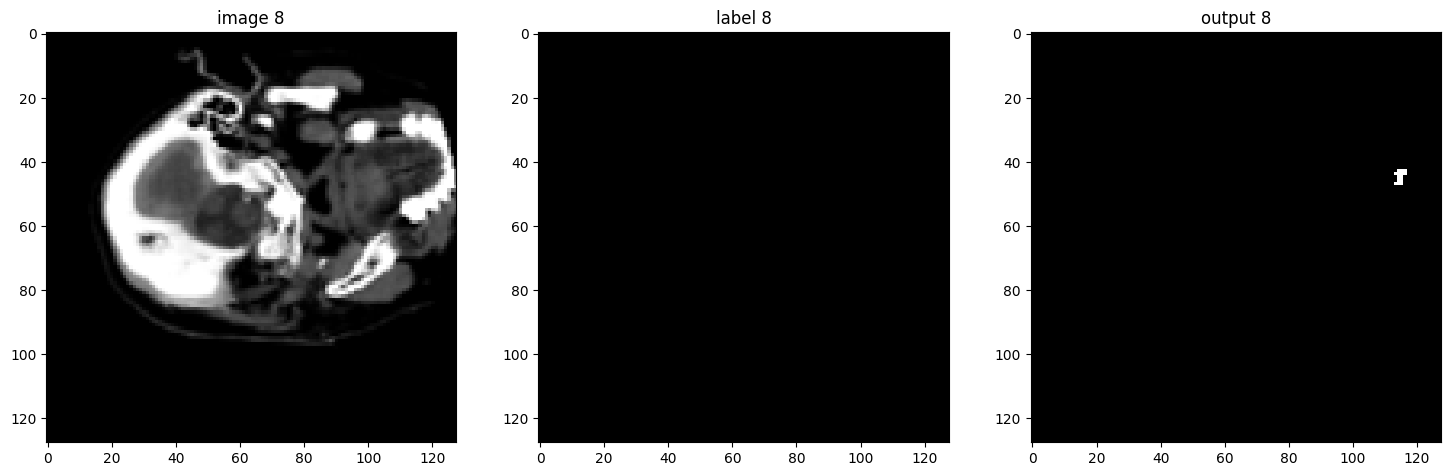

Dice score for slice 9: 5.263154889689758e-07


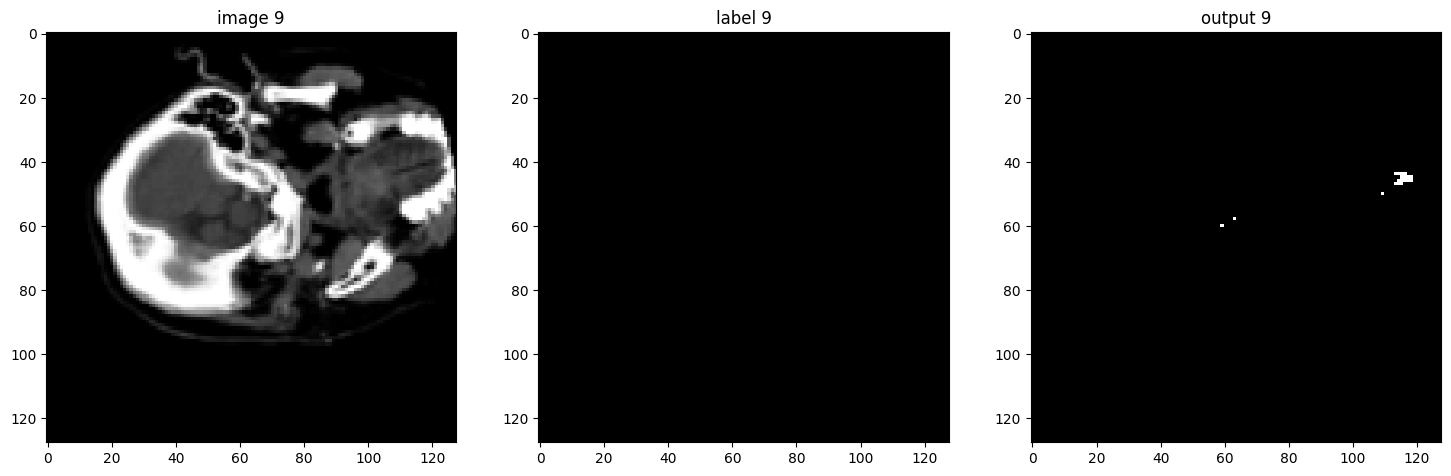

Dice score for slice 10: 4.761902516747796e-07


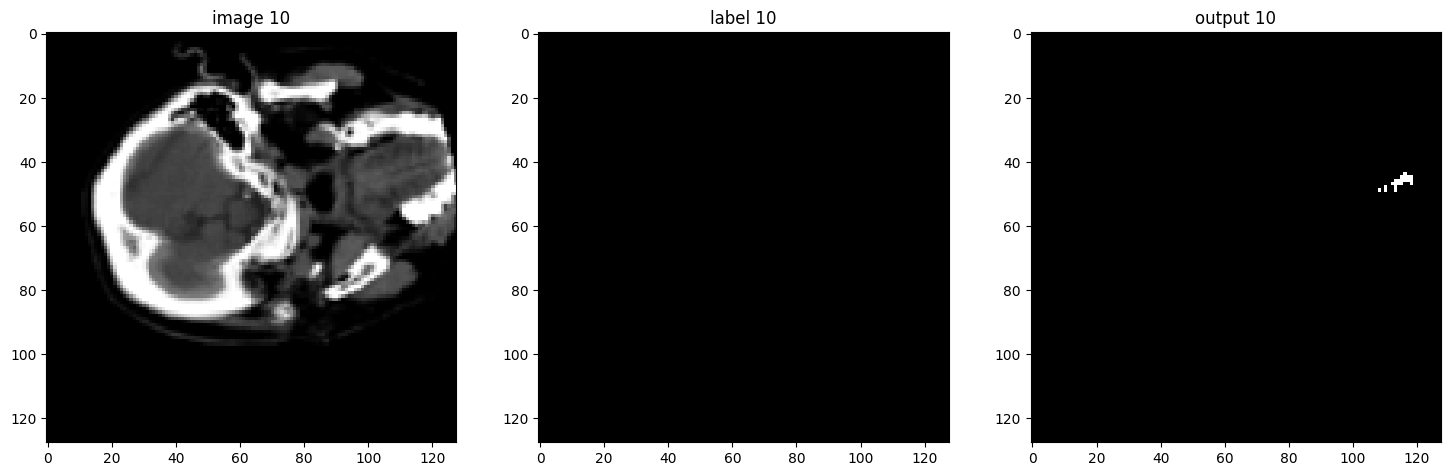

Dice score for slice 11: 1.0


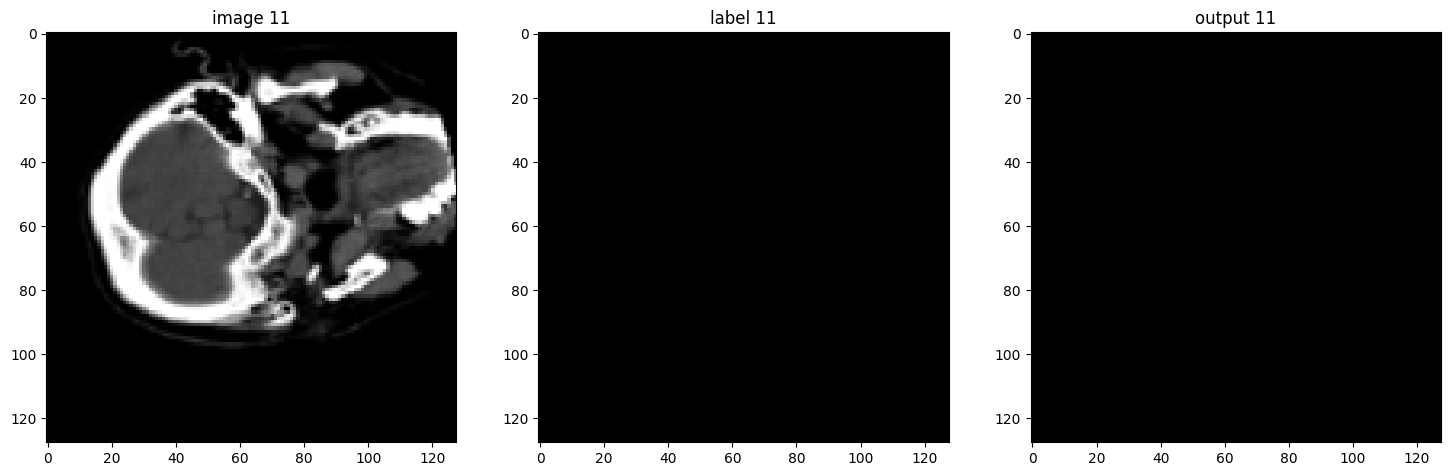

Dice score for slice 12: 1.4285693623605766e-06


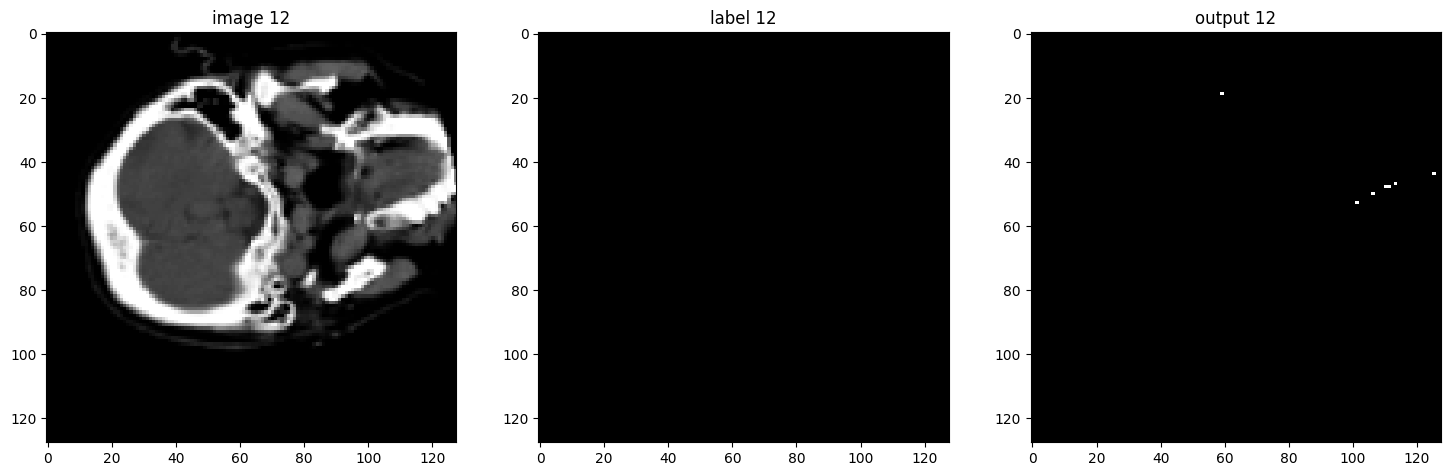

Dice score for slice 13: 9.999899702961557e-06


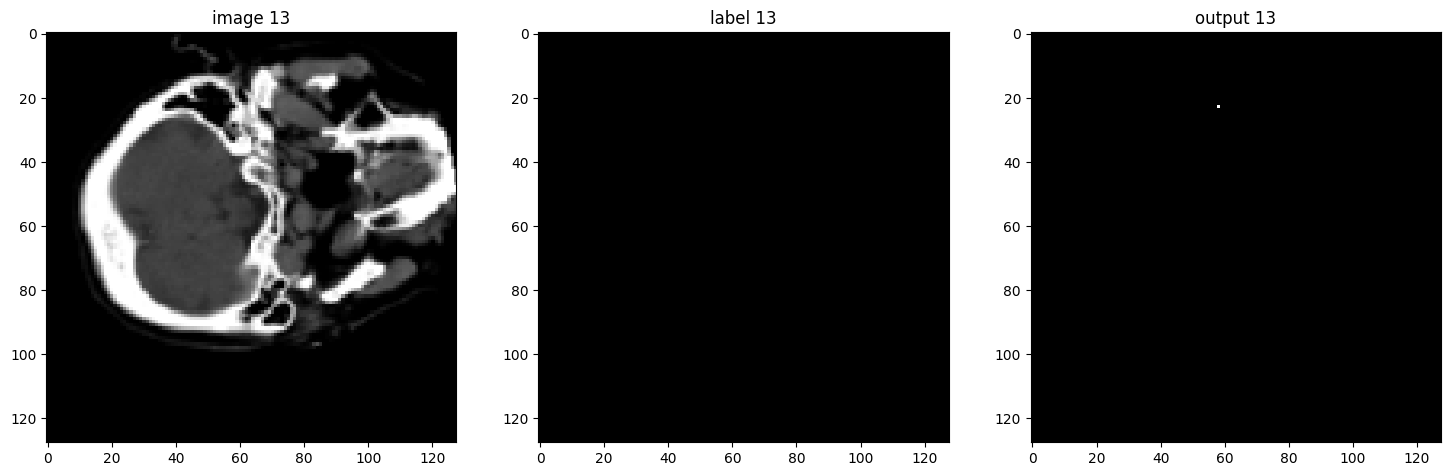

Dice score for slice 14: 8.333326491083426e-07


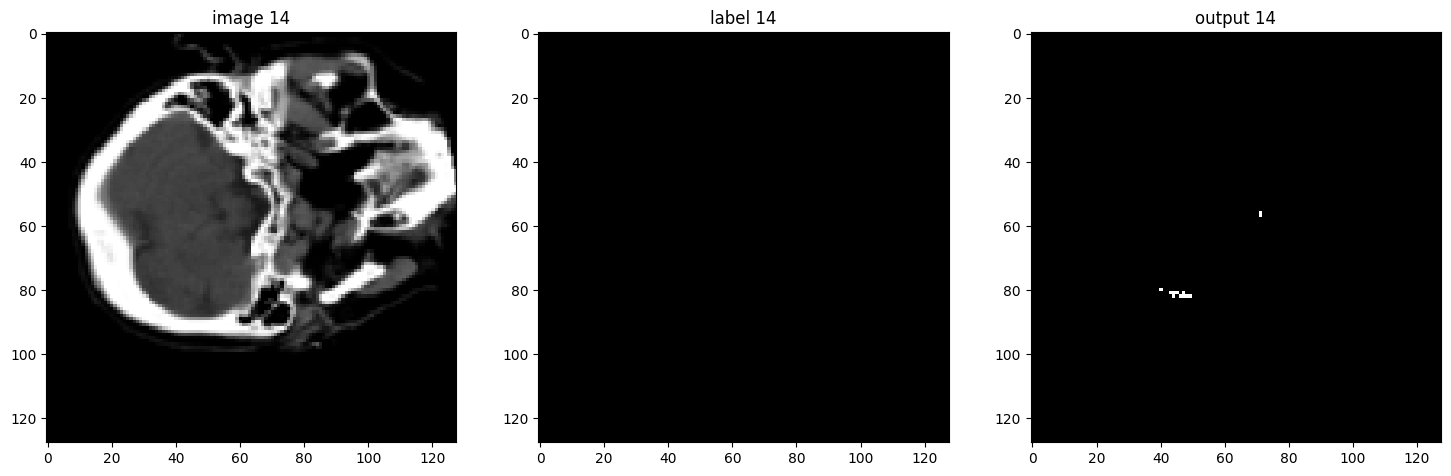

Dice score for slice 15: 3.44827469689335e-07


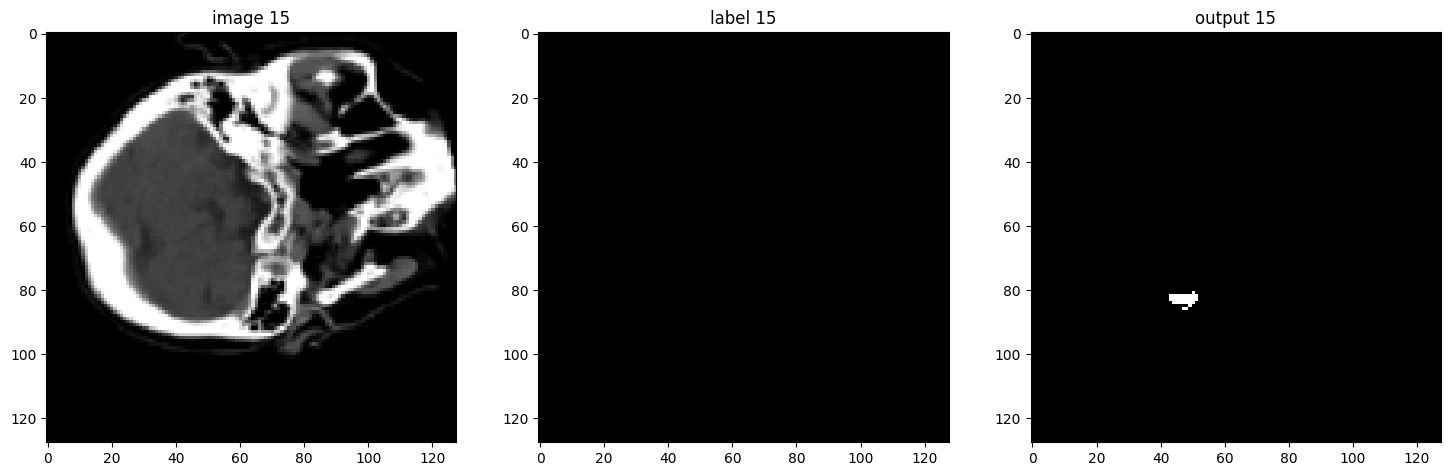

Dice score for slice 16: 2.857141794265772e-07


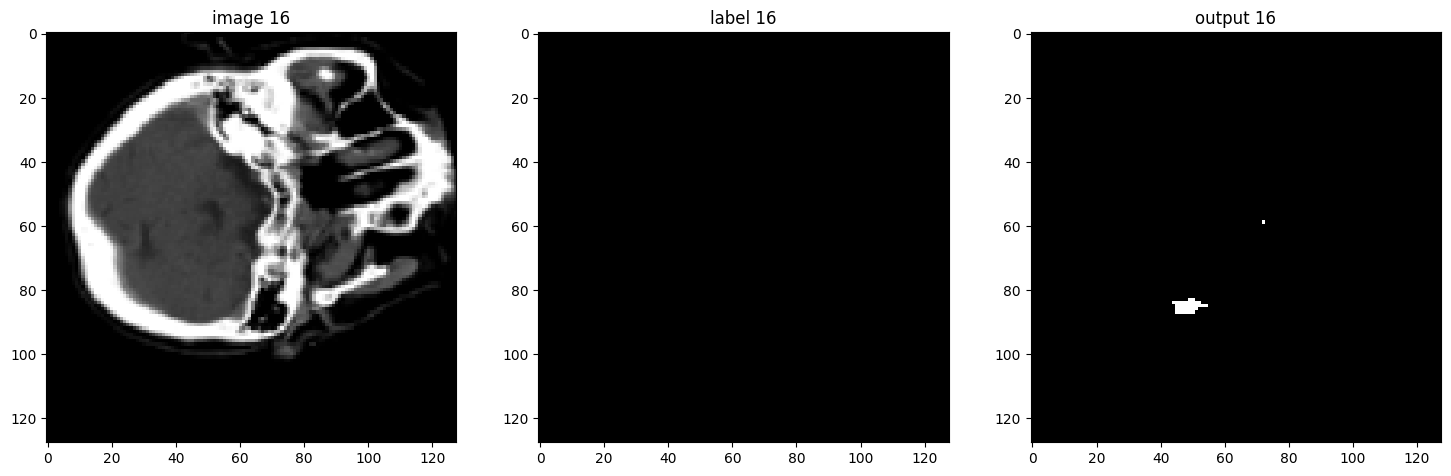

Dice score for slice 17: 3.7037023048469564e-07


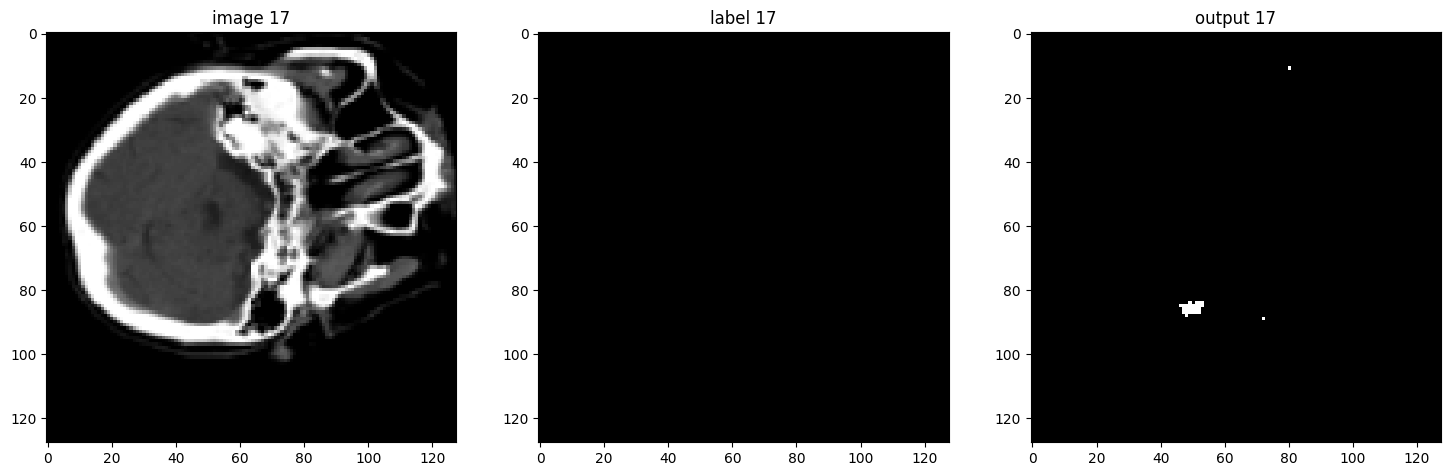

Dice score for slice 18: 1.6666638202877948e-06


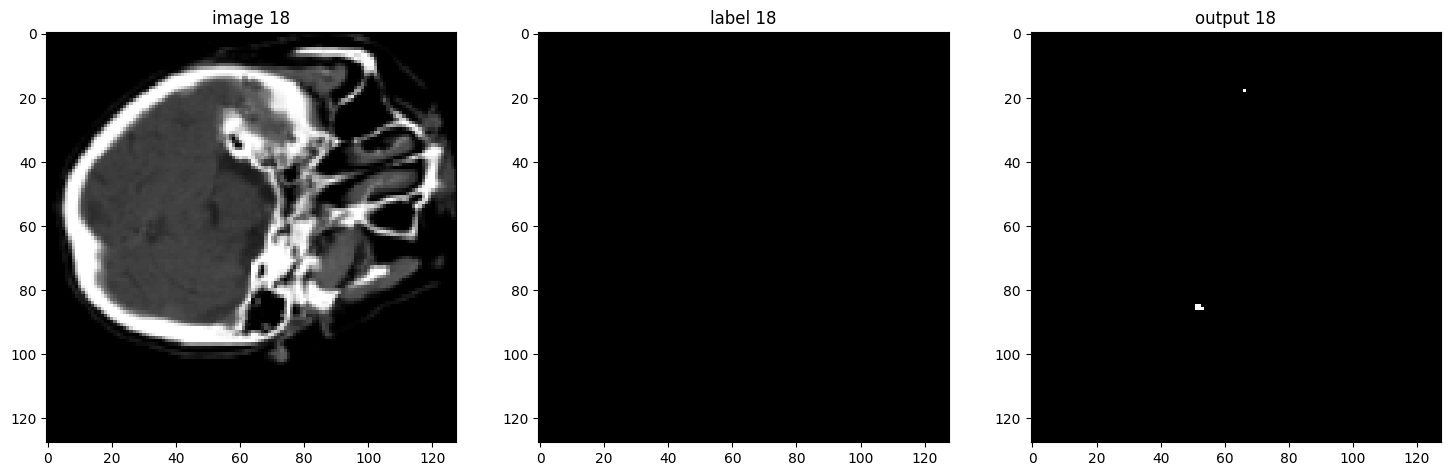

Dice score for slice 19: 4.999974862585077e-06


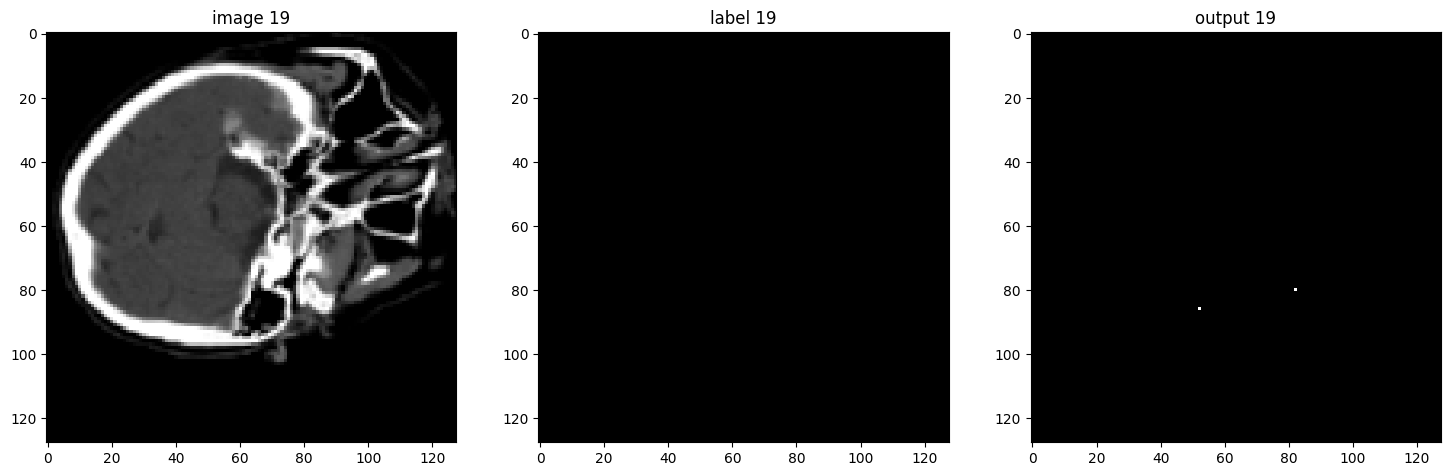

Dice score for slice 20: 1.0


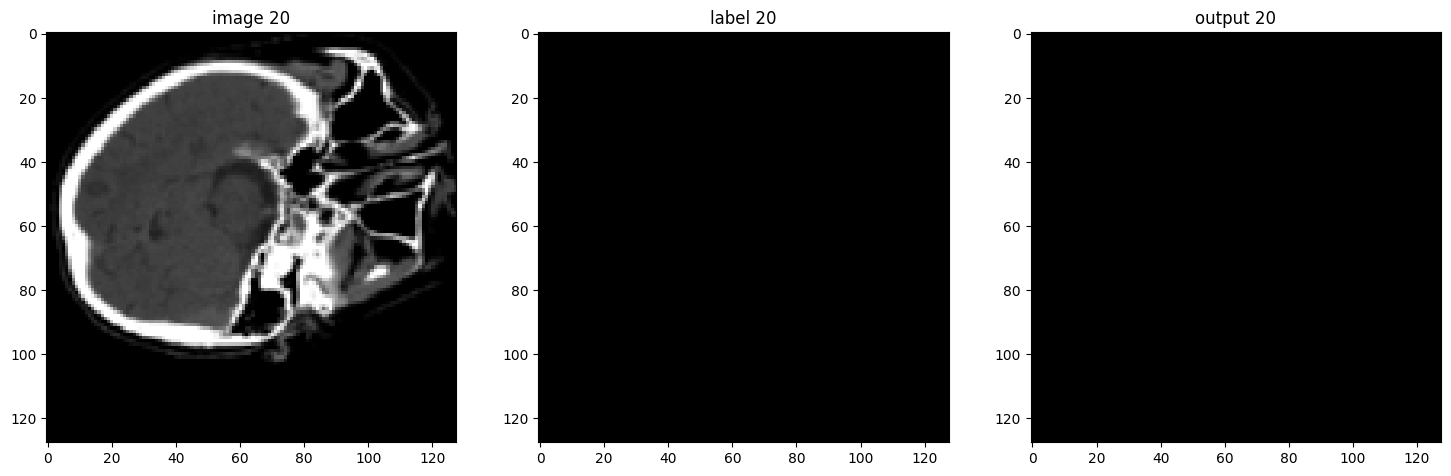

Dice score for slice 21: 9.999899702961557e-06


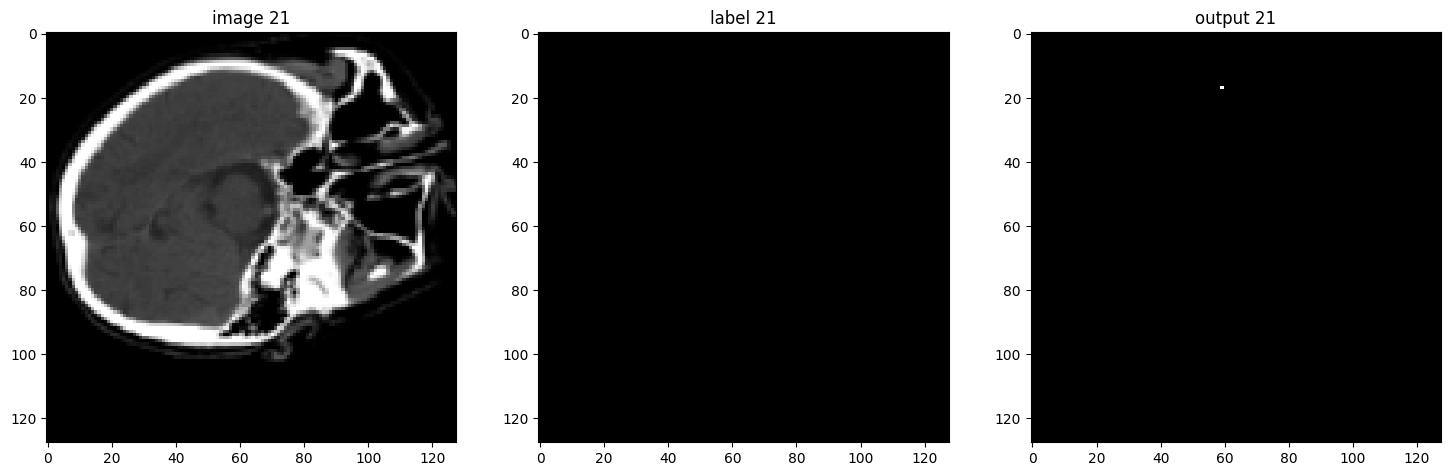

Dice score for slice 22: 2.272726646879164e-07


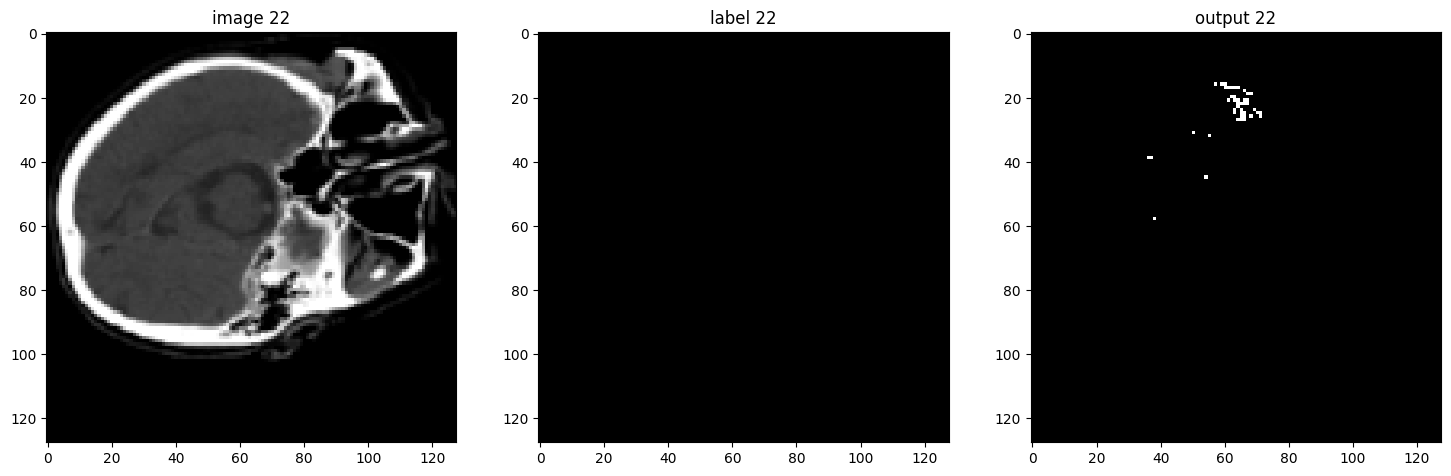

Dice score for slice 23: 8.849556820678117e-08


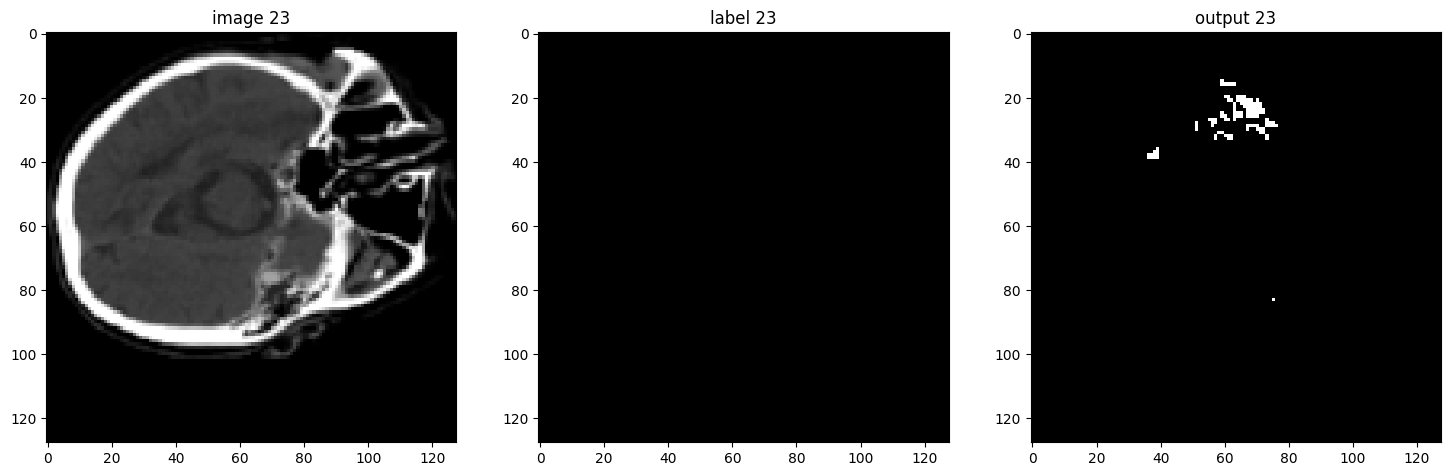

Dice score for slice 24: 5.847952522231026e-08


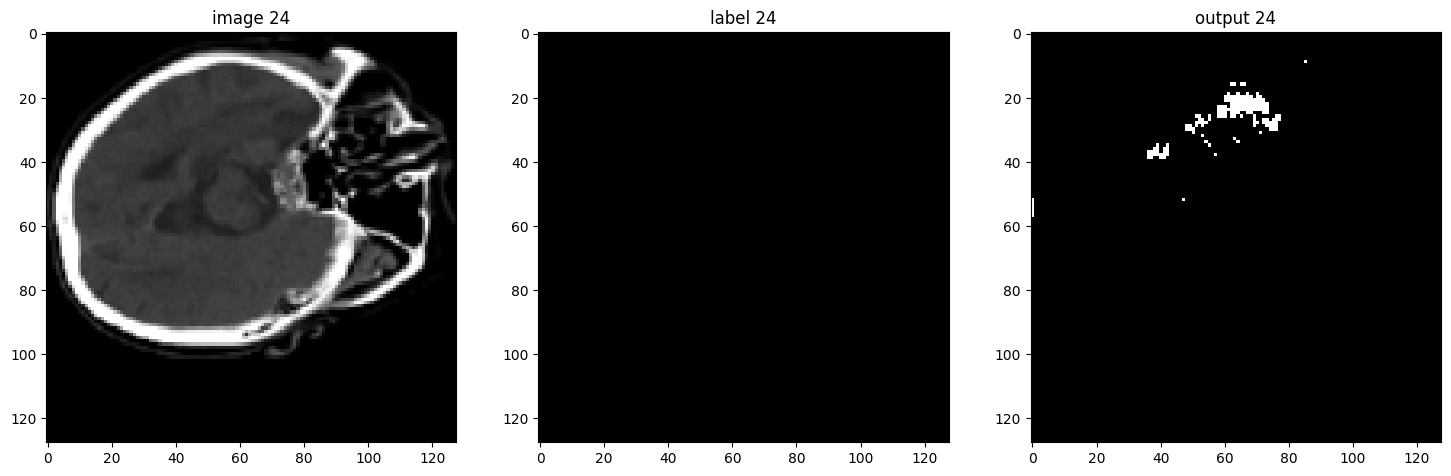

Dice score for slice 25: 5.0761414627231716e-08


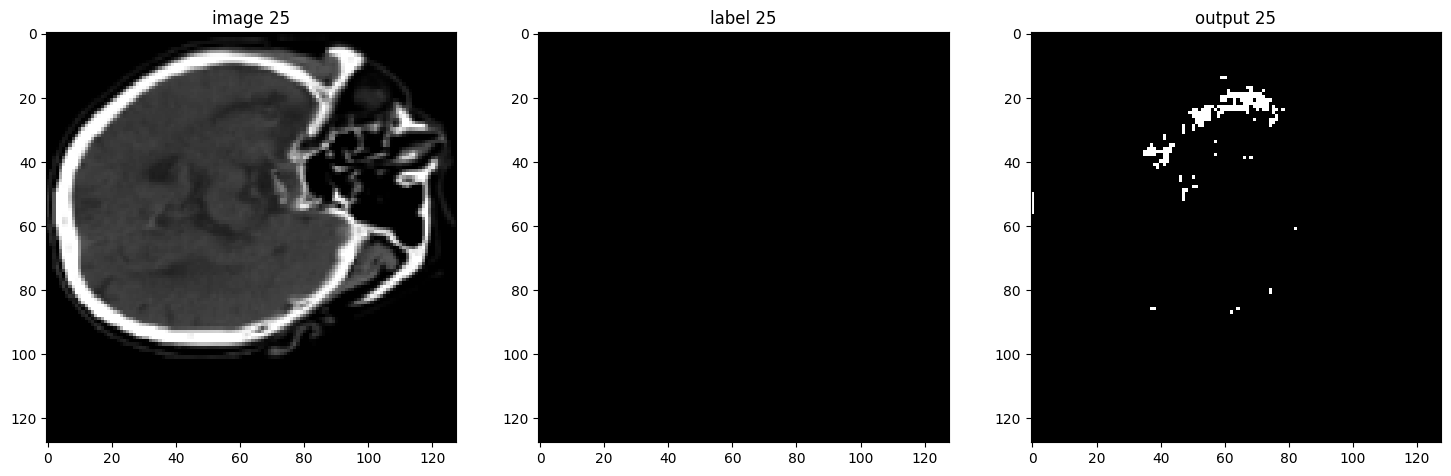

Dice score for slice 26: 4.329003999714587e-08


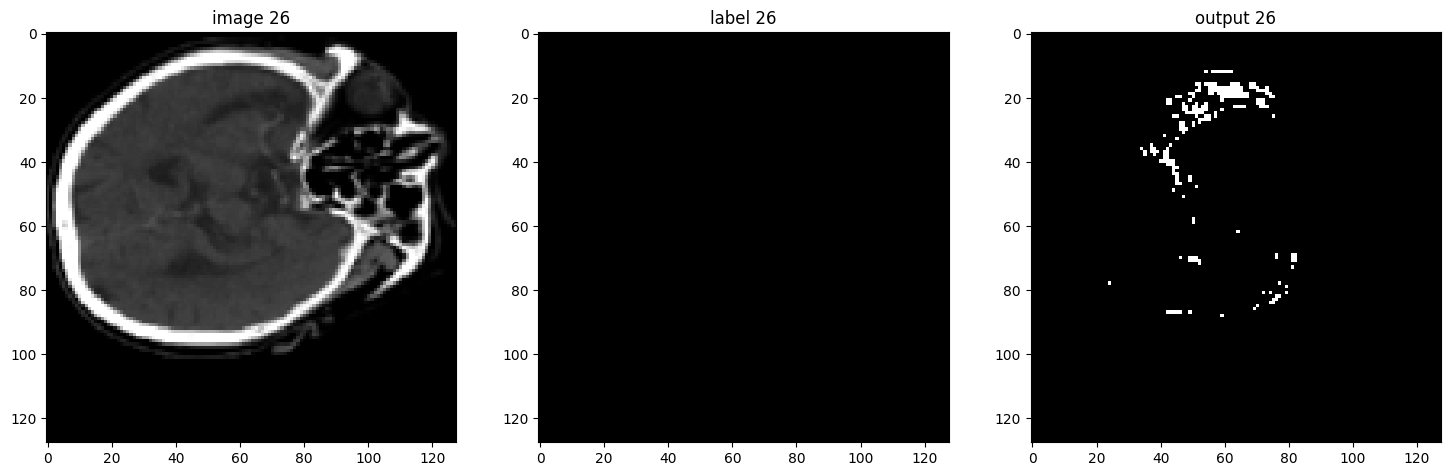

Dice score for slice 27: 0.15094339847564697


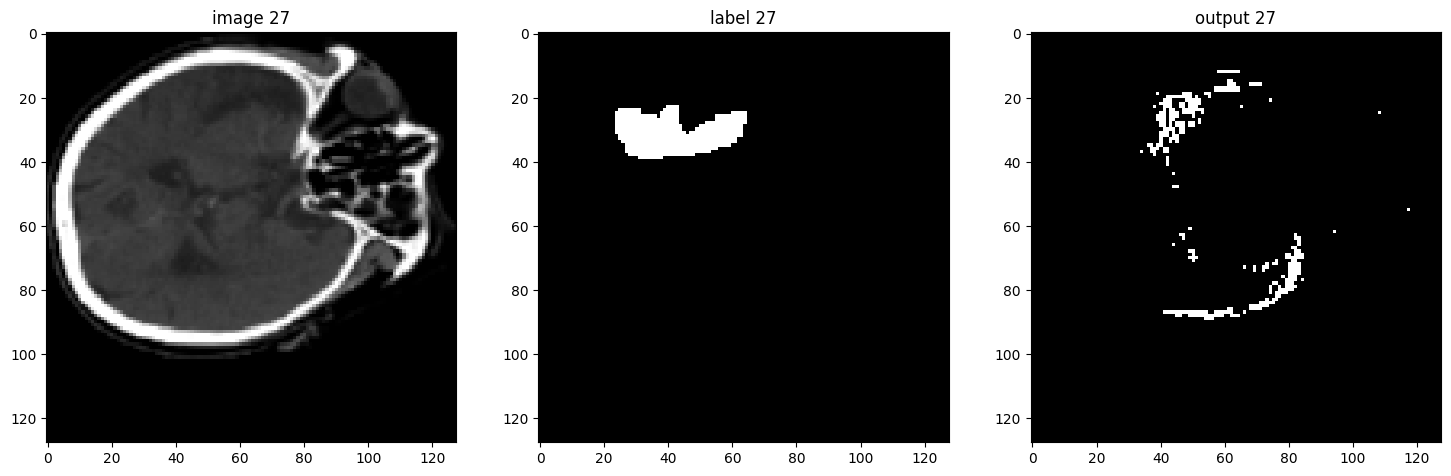

Dice score for slice 28: 0.09609610587358475


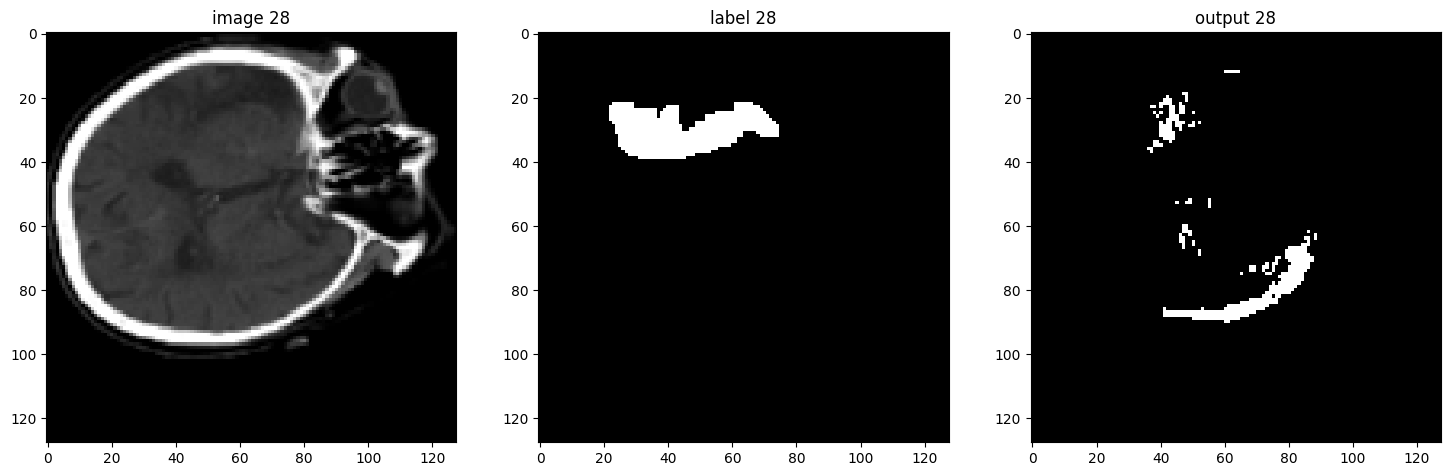

Dice score for slice 29: 0.017857152968645096


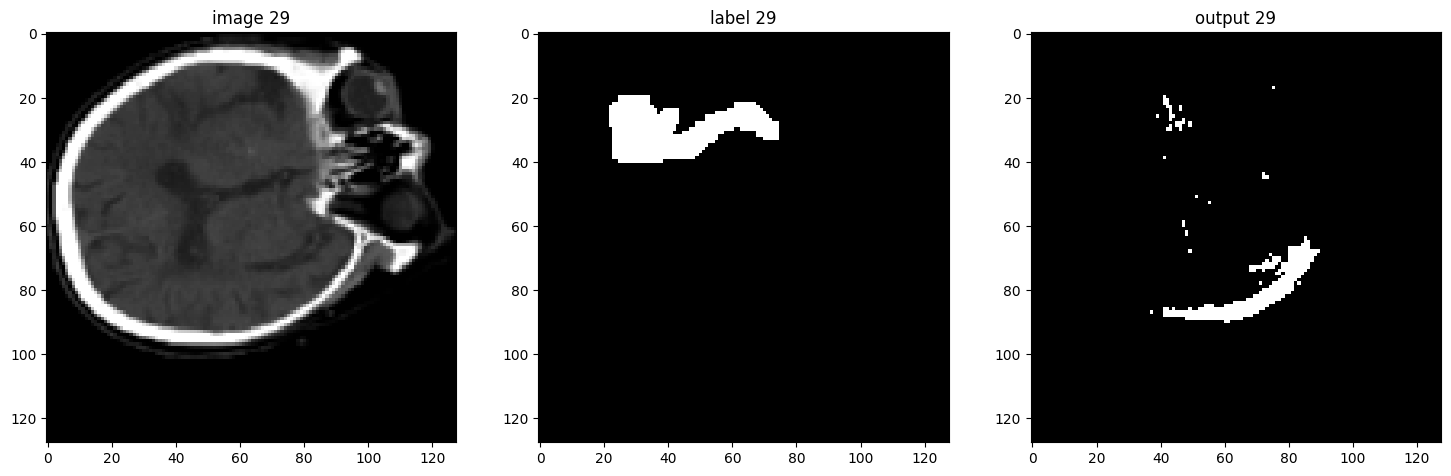

Dice score for slice 30: 0.02841358445584774


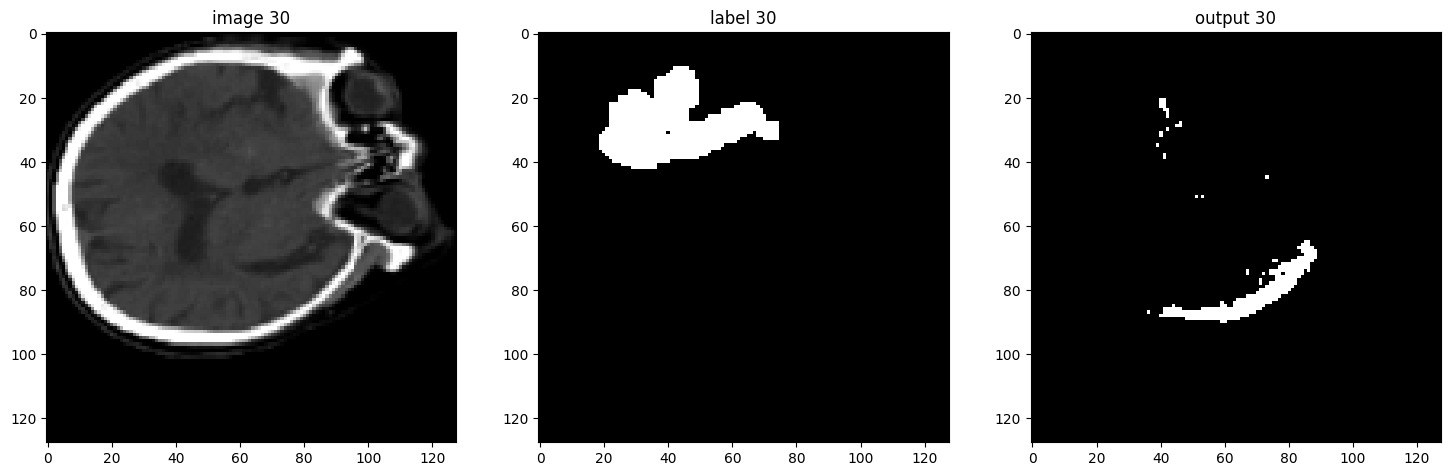

Dice score for slice 31: 0.02145923487842083


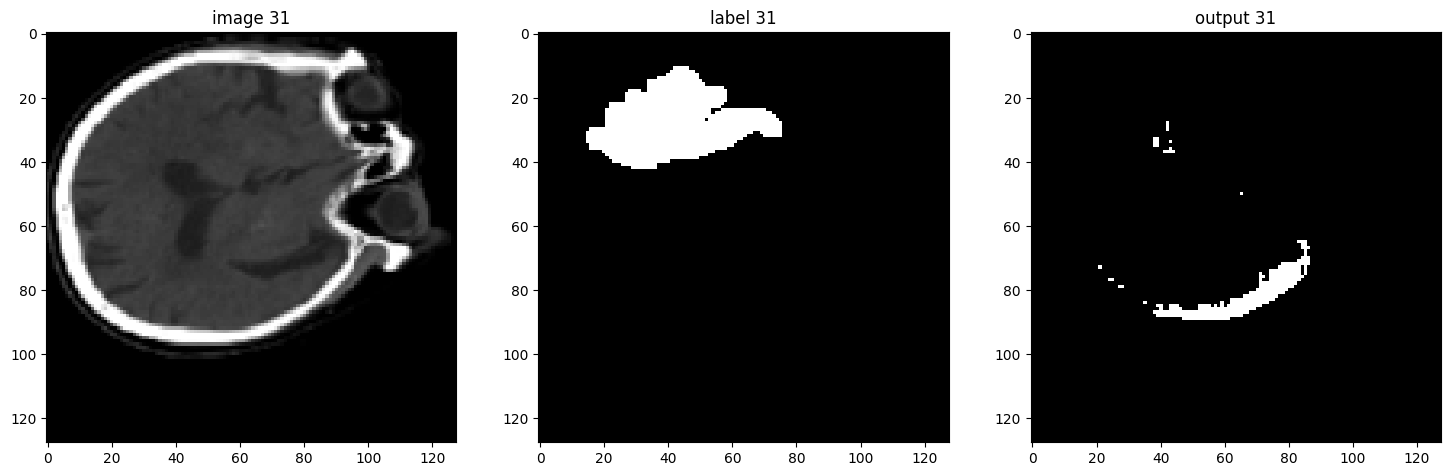

Dice score for slice 32: 0.06716930121183395


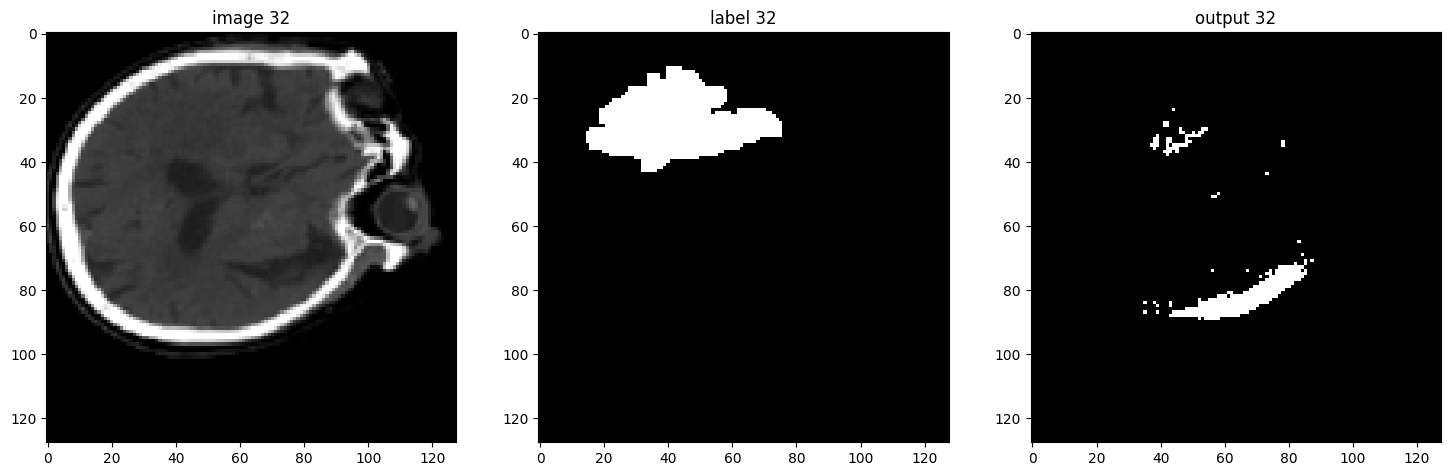

Dice score for slice 33: 0.17125838994979858


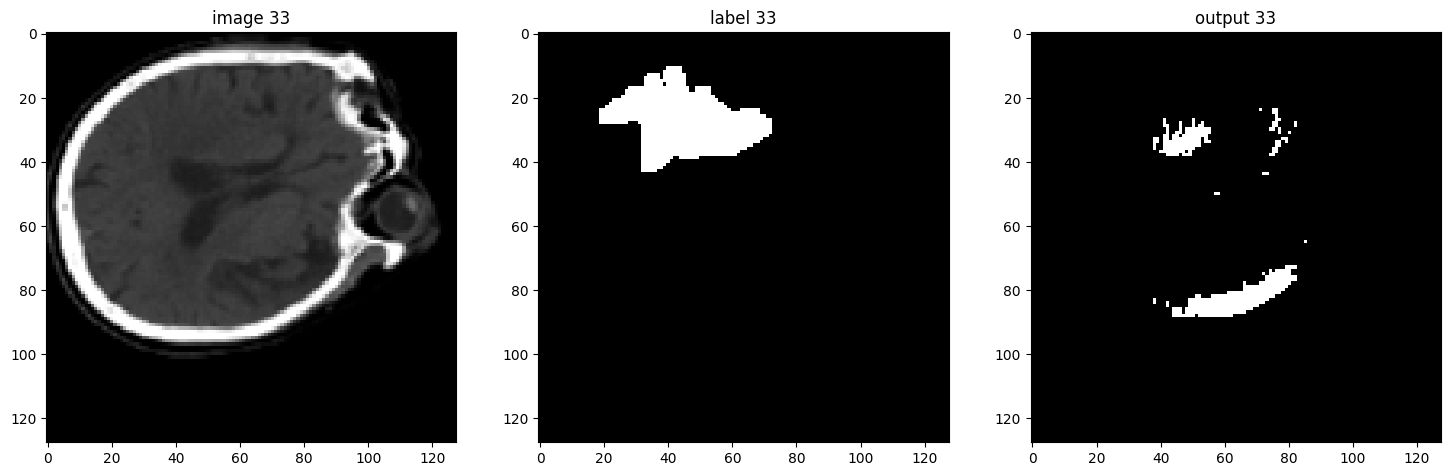

Dice score for slice 34: 0.3554098308086395


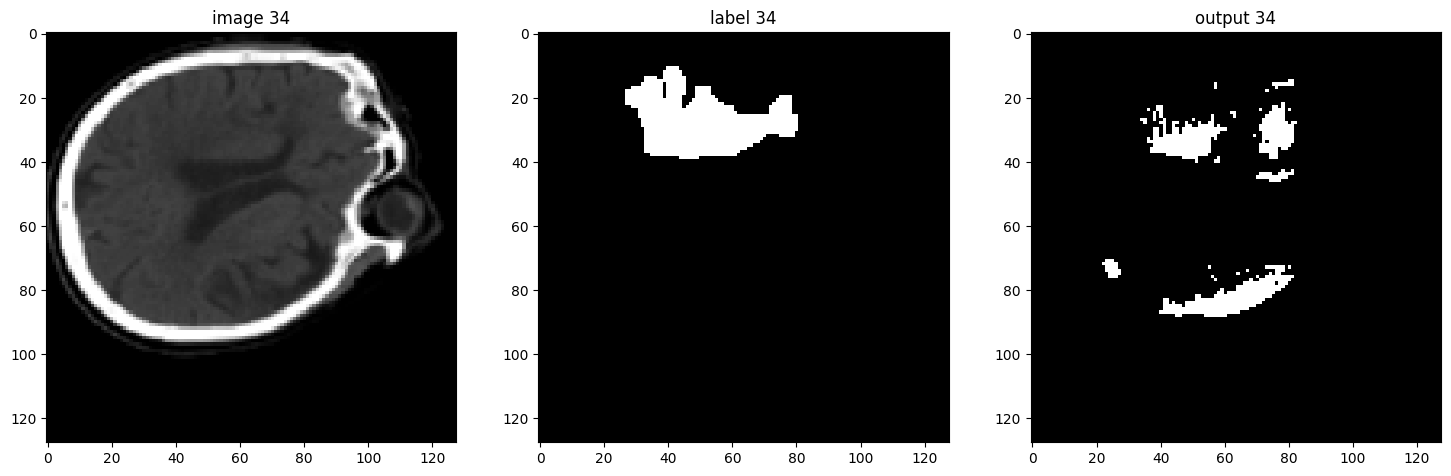

Dice score for slice 35: 0.4270353317260742


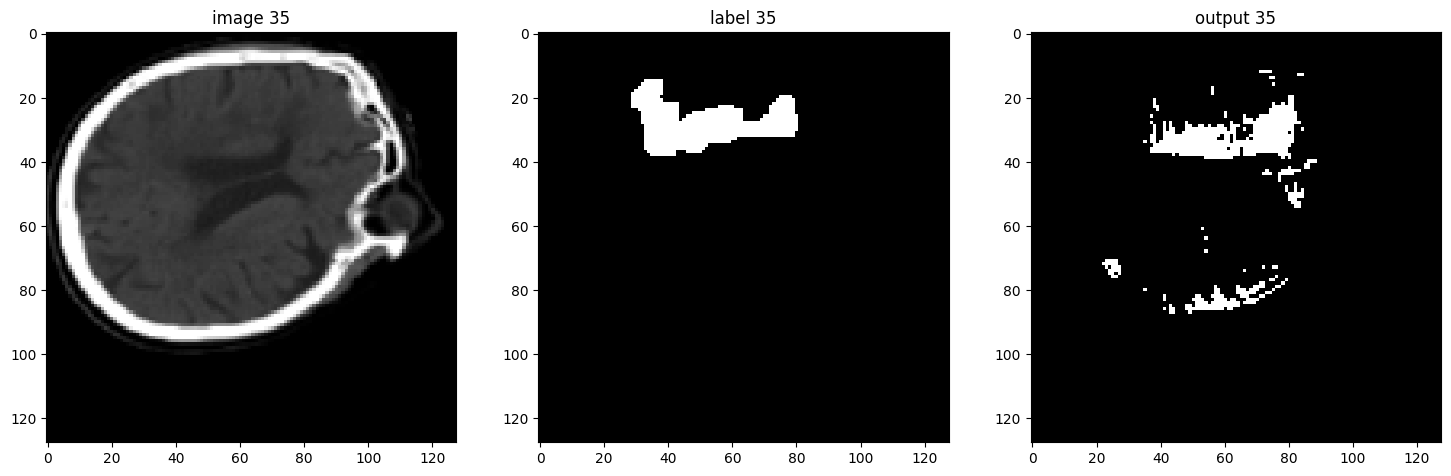

Dice score for slice 36: 0.43095865845680237


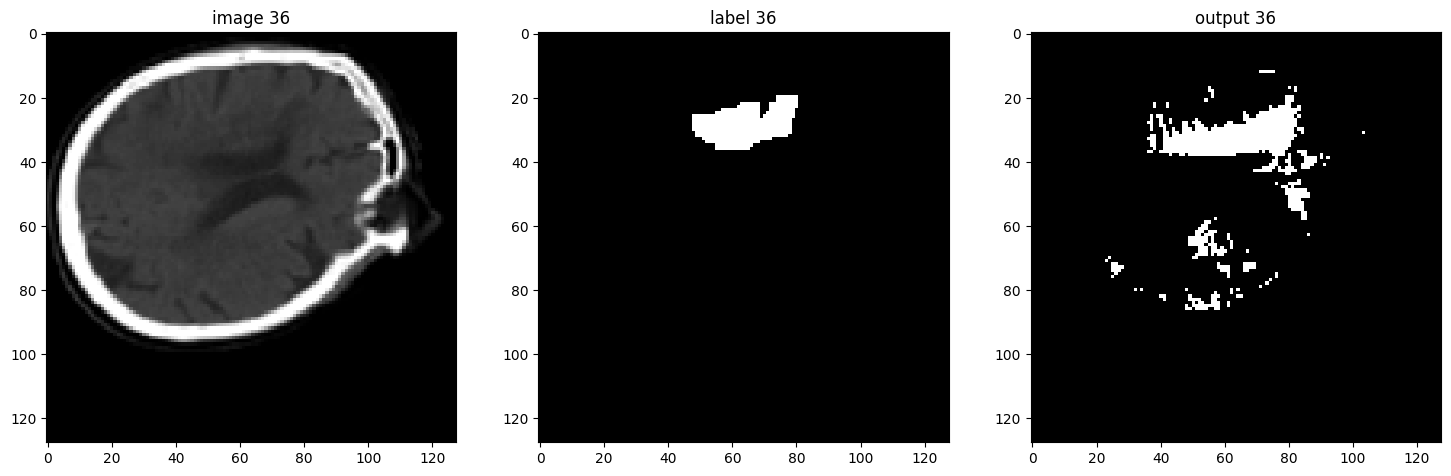

Dice score for slice 37: 0.30958232283592224


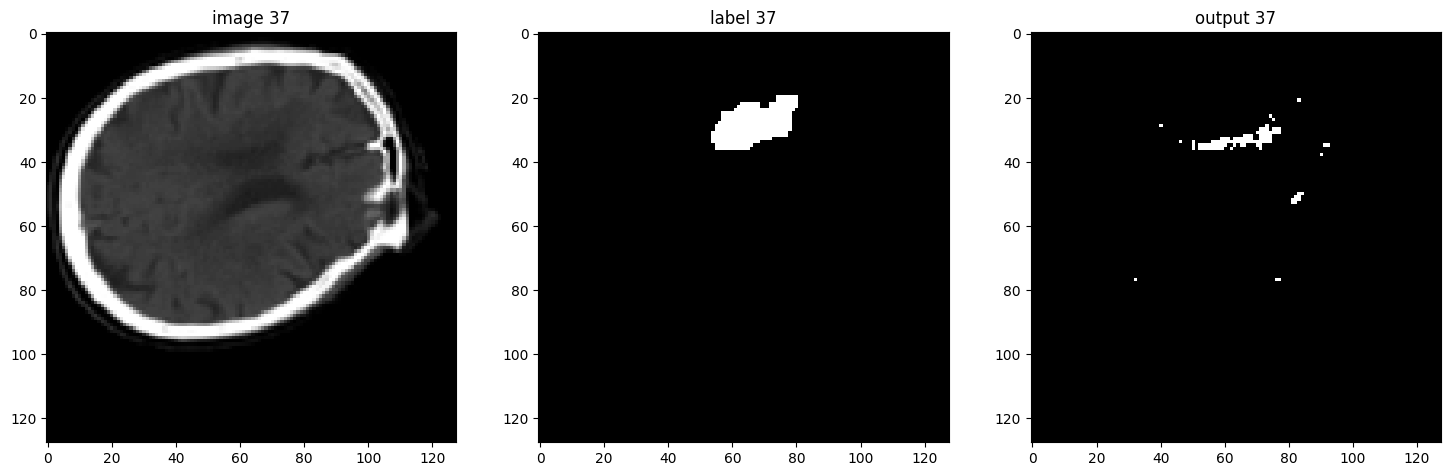

Dice score for slice 38: 5.0761414627231716e-08


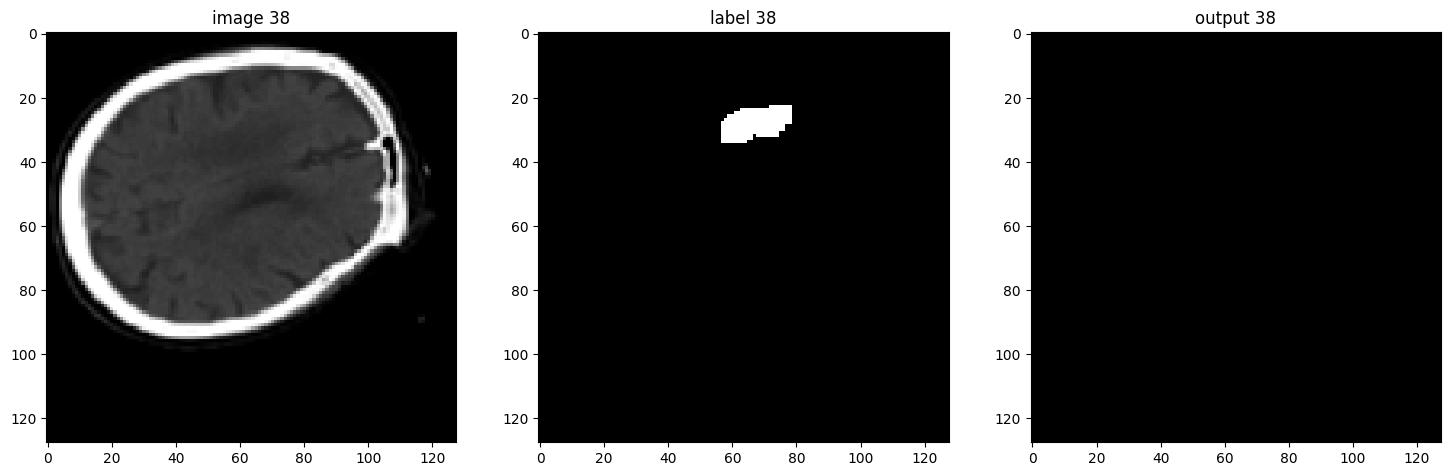

Dice score for slice 39: 1.0


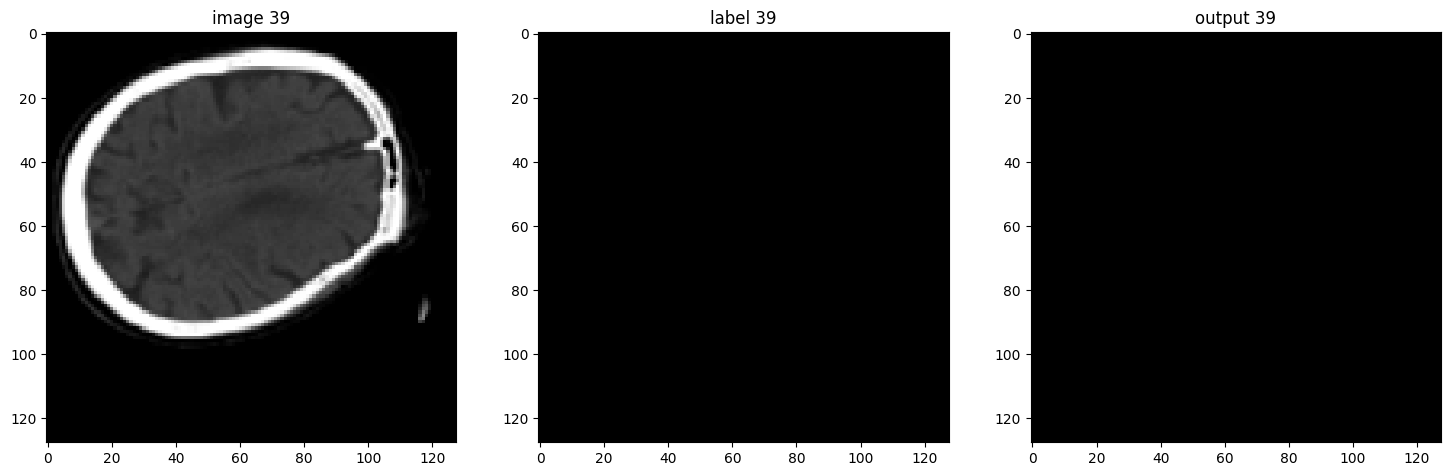

Average Dice score: 0.25190552519666287


In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def dice_score(prediction, target):
    smooth = 1e-5
    intersection = torch.sum(prediction * target)
    union = torch.sum(prediction) + torch.sum(target)
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.item()

sw_batch_size = 1
roi_size = (128, 128, 40)  # adjust as per slices

with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient["vol"]

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.90  # Adjust the threshold as needed
    
    # Calculate and print Dice score for each slice
    dice_scores = []
    for i in range(40):
        slice_label = test_patient["seg"][0, 0, :, :, i] != 0
        slice_output = test_outputs.detach().cpu()[0, 1, :, :, i]  # Assuming a threshold of 0.5 for binary segmentation
        dice = dice_score(slice_output, slice_label)
        dice_scores.append(dice)
        print(f"Dice score for slice {i}: {dice}")

        # Plotting the slice
        plt.figure("Check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0, cmap="gray")
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(slice_output, cmap="gray")
        plt.show()

    # Print average Dice score after the loop
    average_dice = np.mean(dice_scores)
    print(f"Average Dice score: {average_dice}")
